# Artificial Neural Net for Fitting HEA data
  based on
  https://machinelearningmastery.com/neural-network-models-for-combined-classification-and-regression/
  Note that sklearn appears to be part of the scikit package
  as of april 21, set up your venv with python 3.7 so as to be able to use tensorflow

In [1]:
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
import matplotlib as mp
import sys
import tensorflow as tf

!$sys.executable -m pip install tensorflow

from tensorflow.keras import Model
%matplotlib inline
!conda info


     active environment : base
    active env location : C:\Users\19176\anaconda3
       user config file : C:\Users\19176\.condarc
 populated config files : C:\Users\19176\.condarc
          conda version : 4.11.0
    conda-build version : 3.21.6
         python version : 3.9.7.final.0
       virtual packages : __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\19176\anaconda3  (writable)
      conda av data dir : C:\Users\19176\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
          package cache : C:\Users\19176\anaconda3\pkgs
        

### High Entropy Alloys Dataset

In [2]:
#data = pd.read_csv("../Data/Table1.csv", sep = ",") 
data = pd.read_csv("./HEA_Table-Feb2021.csv", sep = ",") 
print(data.head())
display(data)

  Atomic Composition  Al     Co  Cr  Cu     Fe  Hf  Mo  Nb   B  ...  B2  \
0             CoFeNi NaN  33.33 NaN NaN  33.33 NaN NaN NaN NaN  ...   0   
1             CoFeNi NaN  33.33 NaN NaN  33.33 NaN NaN NaN NaN  ...   0   
2             CoFeNi NaN  33.33 NaN NaN  33.33 NaN NaN NaN NaN  ...   0   
3       CoFeNiSi0.25 NaN  30.77 NaN NaN  30.77 NaN NaN NaN NaN  ...   0   
4        CoFeNiSi0.5 NaN  28.57 NaN NaN  28.57 NaN NaN NaN NaN  ...   0   

   ROM Density  Measured Density  Vickers Hardness  Type of Test  \
0          8.5               NaN             125.0             C   
1          8.5               NaN             125.0             C   
2          8.5               NaN               NaN             T   
3          7.7               NaN             149.0             C   
4          7.1               NaN             287.0             C   

   Yield Strength (MPa)  Tensile Strength (MPa)  Elongation (%)  ROM Modulus  \
0                 204.0                     NaN             

,Atomic Composition,Al,Co,Cr,Cu,Fe,Hf,Mo,Nb,B,...,B2,ROM Density,Measured Density,Vickers Hardness,Type of Test,Yield Strength (MPa),Tensile Strength (MPa),Elongation (%),ROM Modulus,Measured Modulus
0,CoFeNi,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,...,0,8.5,NaN,125.0,C,204.0,NaN,NaN,207.0,NaN
1,CoFeNi,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,...,0,8.5,NaN,125.0,C,209.0,NaN,NaN,207.0,NaN
2,CoFeNi,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,...,0,8.5,NaN,NaN,T,211.0,513.0,31.0,207.0,NaN
3,CoFeNiSi0.25,NaN,30.77,NaN,NaN,30.77,NaN,NaN,NaN,NaN,...,0,7.7,NaN,149.0,C,196.0,NaN,NaN,194.0,NaN
4,CoFeNiSi0.5,NaN,28.57,NaN,NaN,28.57,NaN,NaN,NaN,NaN,...,0,7.1,NaN,287.0,C,476.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,CoFeMoNi1.8V,NaN,17.24,NaN,NaN,17.24,NaN,17.24,NaN,NaN,...,0,8.5,NaN,510.0,NaN,NaN,NaN,NaN,NaN,NaN
351,CoFeMoNi2V,NaN,16.67,NaN,NaN,16.67,NaN,16.67,NaN,NaN,...,0,8.5,NaN,382.0,NaN,NaN,NaN,NaN,NaN,NaN
352,CoFeMoNiTiVZr,NaN,14.29,NaN,NaN,14.29,NaN,14.29,NaN,NaN,...,0,7.3,NaN,790.0,NaN,NaN,NaN,NaN,NaN,NaN
353,CuFeNiTiVZr,NaN,NaN,NaN,16.67,16.67,NaN,NaN,NaN,NaN,...,0,6.8,NaN,590.0,NaN,NaN,NaN,NaN,142.0,NaN


In [3]:
data.shape

(355, 39)

- Selecting a column

In [4]:
data.columns

Index(['Atomic Composition', 'Al', 'Co', 'Cr', 'Cu', 'Fe', 'Hf', 'Mo', 'Nb',
       'B', 'C', 'Li', 'Mn', 'Ta', 'Ti', 'Mg', 'Ni', 'Si', 'V', 'Sc', 'Sn',
       'W', 'Zr', 'Zn', 'Y', 'BCC', 'FCC', 'Im', 'HCP', 'B2', 'ROM Density',
       'Measured Density', 'Vickers Hardness', 'Type of Test',
       'Yield Strength (MPa)', 'Tensile Strength (MPa)', 'Elongation (%)',
       'ROM Modulus', 'Measured Modulus'],
      dtype='object')

In [5]:
data['Vickers Hardness']

# loc is primarily label based indexing. Integers may be used but they are interpreted as a label.
# iloc is primarily integer based indexing

data.iloc[:, 32]
data.iloc[:, 32].values

array([125., 125.,  nan, 149., 287., 570., 138., 212., 385.,  nan, 116.,
       113., 210.,  nan,  nan,  nan,  nan,  nan,  nan, 509., 654., 110.,
       113., 131., 196., 159., 209., 624., 388., 280.,  nan, 538., 361.,
       484., 433., 395.,  nan,  nan,  nan,  nan,  nan,  nan, 520., 487.,
       499., 484., 517., 402., 509., 512., 432., 487., 506.,  nan,  nan,
        nan,  nan,  nan,  nan,  nan, 425., 801., 755., 754.,  nan,  nan,
        nan,  nan, 708.,  nan, 796., 715., 730., 586., 395., 741., 586.,
       635., 639., 655., 605., 569., 668., 747.,  nan,  nan,  nan,  nan,
        nan,  nan,  nan, 487., 717.,  nan, 178., 178.,  nan,  nan,  nan,
        nan, 643., 780., 176., 144., 151., 186., 342., 650., 180., 171.,
       182., 183., 220., 278., 405., 486., 530., 539., 533., 535., 539.,
        nan,  nan,  nan,  nan,  nan,  nan, 396., 297., 857., 472., 549.,
       622., 854., 905., 134., 180., 207., 271., 407., 476., 510., 557.,
       567., 603., 624., 657., 644., 172., 132., 28

- Calculating fraction of NaNs in each columns

In [6]:
# % of NaNs
data.isnull().sum()/len(data)

Atomic Composition        0.000000
Al                        0.380282
Co                        0.335211
Cr                        0.380282
Cu                        0.670423
Fe                        0.276056
Hf                        0.918310
Mo                        0.749296
Nb                        0.740845
B                         0.991549
C                         0.974648
Li                        0.980282
Mn                        0.904225
Ta                        0.915493
Ti                        0.636620
Mg                        0.980282
Ni                        0.292958
Si                        0.952113
V                         0.760563
Sc                        0.997183
Sn                        0.954930
W                         0.988732
Zr                        0.816901
Zn                        0.985915
Y                         0.991549
BCC                       0.000000
FCC                       0.000000
Im                        0.000000
HCP                 

In [7]:
# Fixing NaNs
# Remoce missing values
subdata2 = data[np.isfinite(data['Elongation (%)'])]
display(subdata2)
subdata2.shape

,Atomic Composition,Al,Co,Cr,Cu,Fe,Hf,Mo,Nb,B,...,B2,ROM Density,Measured Density,Vickers Hardness,Type of Test,Yield Strength (MPa),Tensile Strength (MPa),Elongation (%),ROM Modulus,Measured Modulus
2,CoFeNi,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,...,0,8.5,NaN,NaN,T,211.0,513.0,31.0,207.0,NaN
9,CoCrFeNi,NaN,25.00,25.00,NaN,25.00,NaN,NaN,NaN,NaN,...,0,8.2,NaN,NaN,T,148.0,413.0,48.0,225.0,NaN
13,CoCrFeNb0.103Ni,NaN,24.37,24.37,NaN,24.37,NaN,NaN,2.51,NaN,...,0,8.2,NaN,NaN,T,318.0,622.0,19.0,NaN,NaN
14,CoCrFeNb0.155Ni,NaN,24.07,24.07,NaN,24.07,NaN,NaN,3.73,NaN,...,0,8.2,NaN,NaN,T,322.0,744.0,23.0,NaN,NaN
15,CoCrFeNb0.206Ni,NaN,23.78,23.78,NaN,23.78,NaN,NaN,4.90,NaN,...,0,8.2,NaN,NaN,T,403.0,807.0,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,NbTiV0.3Mo1.5,NaN,NaN,NaN,NaN,NaN,NaN,39.47,26.32,NaN,...,0,NaN,7.5,NaN,C,1576.0,NaN,8.0,NaN,NaN
335,NbTiVZr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.00,NaN,...,0,NaN,6.5,NaN,C,1104.0,NaN,50.0,NaN,NaN
336,NbTiVZr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.00,NaN,...,0,6.5,NaN,335.0,C,1105.0,NaN,50.0,104.0,NaN
337,NbTiV2Zr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.00,NaN,...,0,6.4,NaN,304.0,C,918.0,NaN,50.0,109.0,NaN


(176, 39)

In [8]:
# % of NaNs
subdata2.isnull().sum()/len(subdata2)

Atomic Composition        0.000000
Al                        0.562500
Co                        0.511364
Cr                        0.539773
Cu                        0.806818
Fe                        0.505682
Hf                        0.840909
Mo                        0.681818
Nb                        0.517045
B                         1.000000
C                         0.948864
Li                        0.982955
Mn                        0.863636
Ta                        0.857955
Ti                        0.437500
Mg                        0.982955
Ni                        0.460227
Si                        0.931818
V                         0.704545
Sc                        1.000000
Sn                        0.926136
W                         0.977273
Zr                        0.687500
Zn                        0.982955
Y                         0.982955
BCC                       0.000000
FCC                       0.000000
Im                        0.000000
HCP                 

### Initial processing for Hardness Model

- Subsetting dataset with respect to Vickers Hardness

In [9]:
# Fixing NaNs
subdata = data[np.isfinite(data['Vickers Hardness'])]
display(subdata)

,Atomic Composition,Al,Co,Cr,Cu,Fe,Hf,Mo,Nb,B,...,B2,ROM Density,Measured Density,Vickers Hardness,Type of Test,Yield Strength (MPa),Tensile Strength (MPa),Elongation (%),ROM Modulus,Measured Modulus
0,CoFeNi,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,...,0,8.5,NaN,125.0,C,204.0,NaN,NaN,207.0,NaN
1,CoFeNi,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,...,0,8.5,NaN,125.0,C,209.0,NaN,NaN,207.0,NaN
3,CoFeNiSi0.25,NaN,30.77,NaN,NaN,30.77,NaN,NaN,NaN,NaN,...,0,7.7,NaN,149.0,C,196.0,NaN,NaN,194.0,NaN
4,CoFeNiSi0.5,NaN,28.57,NaN,NaN,28.57,NaN,NaN,NaN,NaN,...,0,7.1,NaN,287.0,C,476.0,NaN,NaN,NaN,NaN
5,CoFeNiSi0.75,NaN,26.67,NaN,NaN,26.67,NaN,NaN,NaN,NaN,...,0,6.6,NaN,570.0,C,1301.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,CoFeMoNi1.6V,NaN,17.86,NaN,NaN,17.86,NaN,17.86,NaN,NaN,...,0,8.5,NaN,520.0,NaN,NaN,NaN,NaN,NaN,NaN
350,CoFeMoNi1.8V,NaN,17.24,NaN,NaN,17.24,NaN,17.24,NaN,NaN,...,0,8.5,NaN,510.0,NaN,NaN,NaN,NaN,NaN,NaN
351,CoFeMoNi2V,NaN,16.67,NaN,NaN,16.67,NaN,16.67,NaN,NaN,...,0,8.5,NaN,382.0,NaN,NaN,NaN,NaN,NaN,NaN
352,CoFeMoNiTiVZr,NaN,14.29,NaN,NaN,14.29,NaN,14.29,NaN,NaN,...,0,7.3,NaN,790.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# % of NaNs
subdata.isnull().sum()/len(subdata)

Atomic Composition        0.000000
Al                        0.330508
Co                        0.288136
Cr                        0.351695
Cu                        0.648305
Fe                        0.203390
Hf                        0.894068
Mo                        0.754237
Nb                        0.792373
B                         0.987288
C                         1.000000
Li                        0.995763
Mn                        0.881356
Ta                        0.889831
Ti                        0.694915
Mg                        0.995763
Ni                        0.258475
Si                        0.953390
V                         0.783898
Sc                        0.995763
Sn                        0.978814
W                         0.983051
Zr                        0.817797
Zn                        1.000000
Y                         1.000000
BCC                       0.000000
FCC                       0.000000
Im                        0.000000
HCP                 

In [11]:
# selecting all columns between Al and Vickers Hardness
subdata = subdata.loc[:, 'Al':'Vickers Hardness']
subdata.head()

,Al,Co,Cr,Cu,Fe,Hf,Mo,Nb,B,C,...,Zn,Y,BCC,FCC,Im,HCP,B2,ROM Density,Measured Density,Vickers Hardness
0,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,8.5,NaN,125.0
1,NaN,33.33,NaN,NaN,33.33,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,8.5,NaN,125.0
3,NaN,30.77,NaN,NaN,30.77,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,7.7,NaN,149.0
4,NaN,28.57,NaN,NaN,28.57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,1,0,0,7.1,NaN,287.0
5,NaN,26.67,NaN,NaN,26.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,1,0,0,6.6,NaN,570.0


In [12]:
# Removing Measured Density
subdata.drop("Measured Density", axis=1, inplace=True)


In [13]:
# % of NaNs
subdata.isnull().sum()/len(subdata)

Al                  0.330508
Co                  0.288136
Cr                  0.351695
Cu                  0.648305
Fe                  0.203390
Hf                  0.894068
Mo                  0.754237
Nb                  0.792373
B                   0.987288
C                   1.000000
Li                  0.995763
Mn                  0.881356
Ta                  0.889831
Ti                  0.694915
Mg                  0.995763
Ni                  0.258475
Si                  0.953390
V                   0.783898
Sc                  0.995763
Sn                  0.978814
W                   0.983051
Zr                  0.817797
Zn                  1.000000
Y                   1.000000
BCC                 0.000000
FCC                 0.000000
Im                  0.000000
HCP                 0.000000
B2                  0.000000
ROM Density         0.000000
Vickers Hardness    0.000000
dtype: float64

In [14]:
# replacing NaNs with 0
subdata = subdata.fillna(0)
display(subdata)

,Al,Co,Cr,Cu,Fe,Hf,Mo,Nb,B,C,...,Zr,Zn,Y,BCC,FCC,Im,HCP,B2,ROM Density,Vickers Hardness
0,0.0,33.33,0.0,0.00,33.33,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,0,0,0,8.5,125.0
1,0.0,33.33,0.0,0.00,33.33,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,0,0,0,8.5,125.0
3,0.0,30.77,0.0,0.00,30.77,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,0,0,0,7.7,149.0
4,0.0,28.57,0.0,0.00,28.57,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,1,0,0,7.1,287.0
5,0.0,26.67,0.0,0.00,26.67,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,1,0,0,6.6,570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.0,17.86,0.0,0.00,17.86,0.0,17.86,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,1,0,0,8.5,520.0
350,0.0,17.24,0.0,0.00,17.24,0.0,17.24,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,1,0,0,8.5,510.0
351,0.0,16.67,0.0,0.00,16.67,0.0,16.67,0.0,0.0,0.0,...,0.00,0.0,0.0,0,1,1,0,0,8.5,382.0
352,0.0,14.29,0.0,0.00,14.29,0.0,14.29,0.0,0.0,0.0,...,14.29,0.0,0.0,0,0,0,0,0,7.3,790.0


In [15]:
# % of NaNs
subdata.isnull().sum()/len(subdata)

Al                  0.0
Co                  0.0
Cr                  0.0
Cu                  0.0
Fe                  0.0
Hf                  0.0
Mo                  0.0
Nb                  0.0
B                   0.0
C                   0.0
Li                  0.0
Mn                  0.0
Ta                  0.0
Ti                  0.0
Mg                  0.0
Ni                  0.0
Si                  0.0
V                   0.0
Sc                  0.0
Sn                  0.0
W                   0.0
Zr                  0.0
Zn                  0.0
Y                   0.0
BCC                 0.0
FCC                 0.0
Im                  0.0
HCP                 0.0
B2                  0.0
ROM Density         0.0
Vickers Hardness    0.0
dtype: float64

We now have something we can pass to a neural net!

In [100]:
X = subdata.iloc[:, 0:30].values
y = subdata.iloc[:, 30].values
X, y = X.astype('float'), y.astype('float')
n_features = X.shape[1]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
#test_size =0.2-0.3

The model will have two hidden layers, the first with 20 nodes and the second with 10 nodes, both using ReLU activation and “he normal” weight initialization (a good practice). The number of layers and nodes were chosen arbitrarily.

The output layer will have a single node for predicting a numeric value and a linear activation function.

In [101]:
# define the keras model
#  note the added import, see https://keras.io/about/
from tensorflow.keras.models import Sequential
model = Sequential()
#model = tf.keras.Sequential()
#  note the added import, see https://keras.io/about/
from tensorflow.keras.layers import Dense
model.add(Dense(20, input_dim=n_features, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear'))

In [102]:
# functions to calculate score for both datasets
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def mean_absolute_error(x,y): return math.sqrt((abs(x-y)).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Compile the model

In [105]:
# compile the keras model
model.compile(loss='mse', optimizer='adam')

## train the model for 150 epochs with a mini-batch size of 32 samples; we may alter these 2 hyperparameters.

In [106]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
6/6 [==============================] - 1s 3ms/step - loss: nan
Epoch 2/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 5/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 7/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 8/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 9/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 10/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 11/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 12/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 13/150
6/6 [==============================] - 0s 4ms/step - loss: nan
Epoch 14/150
6/6 [===

6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 109/150
6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 110/150
6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 111/150
6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 112/150
6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 113/150
6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 114/150
6/6 [==============================] - 0s 3ms/step - loss: nan
Epoch 115/150
6/6 [==============================] - 0s 3ms/step - loss: nan
Epoch 116/150
6/6 [==============================] - 0s 3ms/step - loss: nan
Epoch 117/150
6/6 [==============================] - 0s 3ms/step - loss: nan
Epoch 118/150
6/6 [==============================] - 0s 2ms/step - loss: nan
Epoch 119/150
6/6 [==============================] - 0s 3ms/step - loss: nan
Epoch 120/150
6/6 [==============================] - 0s 3ms/step - loss: nan
Epoch 121/150

## after the model is trained, we will evaluate it on the holdout test dataset and report the mean absolute error (MAE).

In [99]:
#evaluate on test set
#yhat = true value
yhat = model.predict(X_test)
error = mean_absolute_error(y_test, yhat)
sizeXtest = np.size(X_test)
sizeXtrain = np.size(X_train)
sizeytrain = np.size(y_train)
sizeytest = np.size(y_test)
size_yhat = np.size(yhat)
print('sizes of sizeXtrain, X_test, y_test, yhat ',sizeXtrain, sizeXtest, sizeytrain, sizeytest, size_yhat)
print('X_test.shape ... ', X_test.shape)
print('MSE: %.3f' % error)

sizes of sizeXtrain, X_test, y_test, yhat  5070 2010 169 67 67
X_test.shape ...  (67, 30)
MSE: nan


In [51]:
np.mean(y)

458.58474576271186

## plot the model 

In [52]:
#  standard plot

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


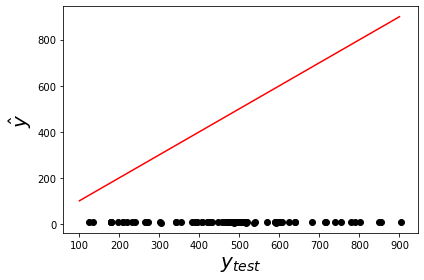

In [53]:
from matplotlib import pyplot as plt
plt.subplots_adjust( left = 0.16, bottom = 0.15 , top = 0.85 )
plt.scatter( y_test, yhat, color='black')
plt.xlabel("$y_{test}$",fontsize = 20, weight = 'bold')
plt.ylabel("$\hat{y}$",fontsize = 20, weight = 'bold')
xx = [100,900]
yy = [100, 900]
plt.plot( xx, yy, color="red")
#plt.set_xlabel= 'y_test'
#plt.set_ylabel= 'yhat'
plt.tight_layout()
plt.savefig('Plot-compare-data-vs-fitted.png', dpi=600)

In [91]:
# classification mlp model for the abalone dataset
from numpy import unique
from numpy import argmax
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Classification ANN
# load dataset
dataset = subdata.values
# split into input (X) and output (y) variables
X, y = dataset[:, 1:-1], dataset[:, -1]
X, y = X.astype('float'), y.astype('float')
n_features = X.shape[1]

# encode strings to integer
y = LabelEncoder().fit_transform(y)
n_class = len(unique(y))

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# define the keras model
#  note the added import, see https://keras.io/about/
from tensorflow.keras.models import Sequential
model = Sequential()
#model = tf.keras.Sequential()
#  note the added import, see https://keras.io/about/
from tensorflow.keras.layers import Dense
model.add(Dense(20,
                input_dim=n_features, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(n_features, activation='softmax'))



In [92]:
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [93]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=2)
# evaluate on test set
yhat = model.predict(X_test)
yhat = argmax(yhat, axis=-1).astype('int')
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)

Epoch 1/150


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\19176\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\19176\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\19176\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\19176\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\19176\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\19176\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\19176\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\19176\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\19176\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\19176\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\19176\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\19176\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\19176\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\19176\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\19176\AppData\Local\Temp/ipykernel_9008/178481179.py", line 2, in <module>
      model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=2)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\19176\anaconda3\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 172 which is outside the valid range of [0, 29).  Label values: 142 108 54 25 85 101 58 155 2 144 118 32 62 159 88 124 1 38 5 78 147 41 28 162 116 128 172 92 104 7 108 45
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_16483]

In [ ]:
#  standard plot

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from matplotlib import pyplot as plt
plt.subplots_adjust( left = 0.16, bottom = 0.15 , top = 0.85 )
plt.scatter( y_test, yhat, color='black')
plt.xlabel("$y_{test}$",fontsize = 20, weight = 'bold')
plt.ylabel("$\hat{y}$",fontsize = 20, weight = 'bold')
xx = [100,900]
yy = [100, 900]
plt.plot( xx, yy, color="red")
#plt.set_xlabel= 'y_test'
#plt.set_ylabel= 'yhat'
plt.tight_layout()
plt.savefig('Plot-compare-data-vs-fitted.png', dpi=600)